In [29]:
import pandas as pd
import folium

[2]: Lager kart over fiskefartøy som har fisket i et spesifikt område.

In [30]:


# Load the dataset
filepath = "GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv"
df = pd.read_csv(filepath, sep=';', decimal=',')


In [31]:
df['Redskap FDIR (kode)'].value_counts()

Redskap FDIR (kode)
51.0    120487
61.0     51615
32.0     43992
55.0     22421
20.0     19277
50.0     15870
11.0     12711
42.0      6818
52.0      3335
58.0      2836
53.0      2732
54.0      1512
22.0       649
70.0       494
80.0       462
33.0        19
34.0        16
Name: count, dtype: int64

[2]: Spesifisere hva som skal undersøkes:

In [32]:
area = 28
fish_type = 'Torsk'
vessel_lenght = '28 m og over'
redskap = 51


[3]: Neste kode viser antall båter over 28m som tråler i område 28 (dvs vest for sognefjorden) fordelt på månedene. Ser her at februar, april, juli og august skiller seg ut. Forklaring av fangsområder: https://portal.fiskeridir.no/portal/home/webmap/viewer.html?layers=ea896a56a80549809360c46896cb8043


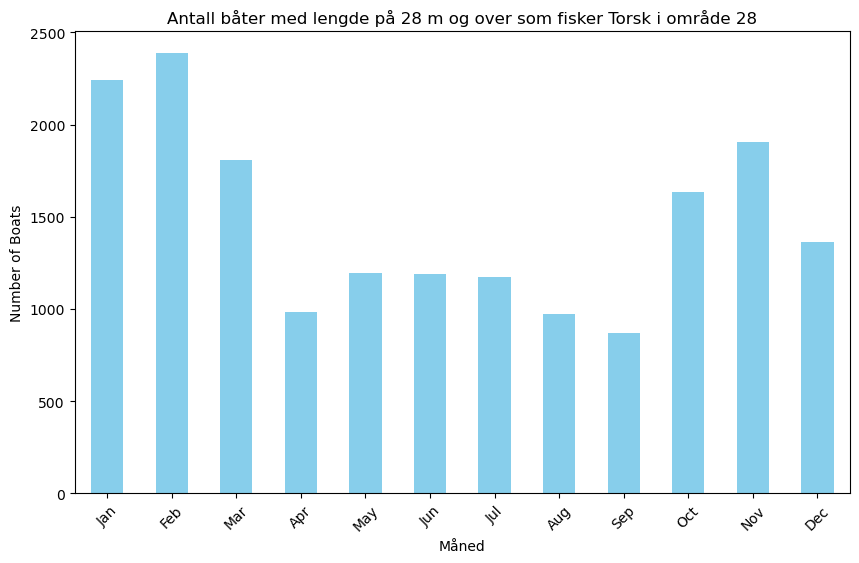

In [38]:
import matplotlib.pyplot as plt

# Convert 'Meldingsdato' to datetime and extract the month
df['Meldingsdato'] = pd.to_datetime(df['Meldingsdato'], format='%d.%m.%Y', errors='coerce')
df['Month'] = df['Meldingsdato'].dt.month

# Filter the DataFrame based on the conditions
filtered_df = df[
    (df['Hovedområde start (kode)'] == area) &
    (df['Lengdegruppe'] == vessel_lenght) &
    (df['Art - gruppe'] == fish_type) | (df['Art - gruppe'] == 'Hyse') &
    (df['Redskap FDIR (kode)'] == redskap)
]

# Group by month and count the number of rows for each month
monthly_counts = filtered_df.groupby('Month').size()

# Create a Series for all months with zeros
all_months = pd.Series(0, index=range(1, 13))

# Update the Series with the actual counts
all_months.update(monthly_counts)

# Create a bar plot with all months
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Antall båter med lengde på {vessel_lenght} som fisker {fish_type} i område {str(area)}')
plt.xlabel('Måned')
plt.ylabel('Number of Boats')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

"Fiskeridirektoratet presiserer at fangst alltid skal rapporteres per art i rund vekt i det elektroniske rapporteringssystemet (ERS). 
Med rund vekt menes den vekten fisken har når den blir tatt om bord i båten, inkludert mageinnhold med videre, og før eventuell bearbeiding."

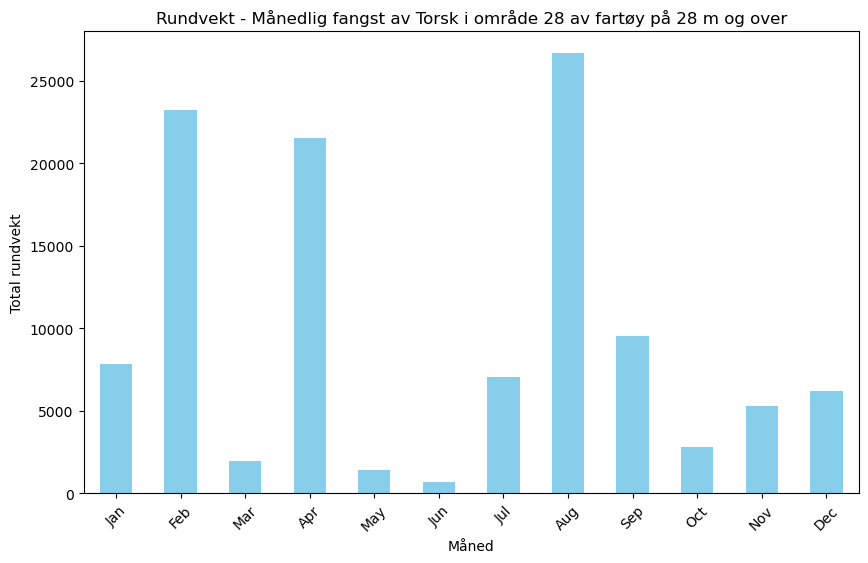

In [34]:

# Gruppert med summen av fangst.
monthly_weights = filtered_df.groupby('Month')['Rundvekt'].sum()

# Create a Series for all months with zeros
all_months = pd.Series(0, index=range(1, 13))

# Update the Series with the actual counts
all_months.update(monthly_weights)

# Create a bar plot with all months
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Rundvekt - Månedlig fangst av {fish_type} i område {str(area)} av fartøy på {vessel_lenght}')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

[4]:Vekt per båt

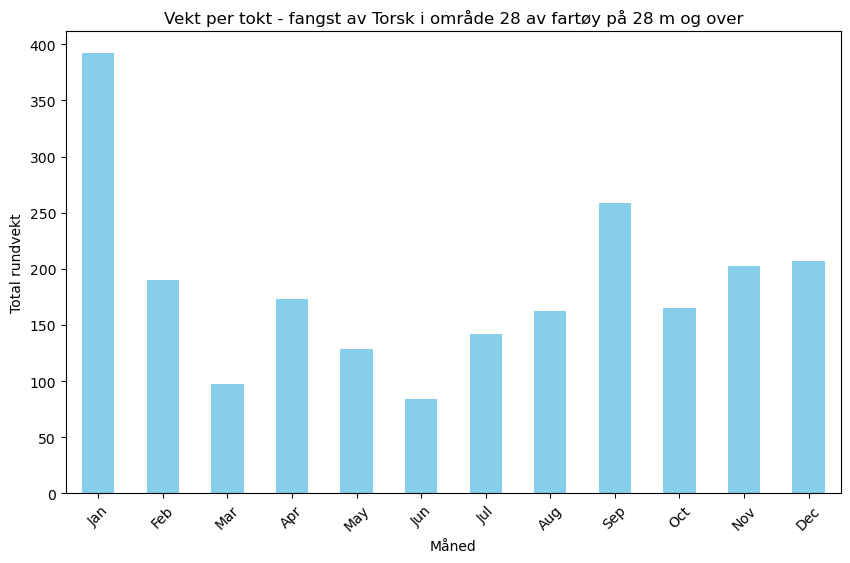

In [35]:
weight_per_boat = monthly_weights/monthly_counts


# Create a Series for all months with zeros
all_months = pd.Series(0.0, index=range(1, 13))

# Update the Series with the actual counts
all_months.update(weight_per_boat)

# Create a bar plot with all months
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Vekt per tokt - fangst av {fish_type} i område {str(area)} av fartøy på {vessel_lenght}')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Generer kart over fangst i et bestemt område.

In [36]:
# Create a Folium map centered at a specific location
m = folium.Map(location=[65, 15], zoom_start=5)  # Adjust the location and zoom level as needed

# Add markers for each fishing boat location
for index, row in df.iterrows():
    if (row['Hovedområde start (kode)'] == 28) and \
            (row['Lengdegruppe'] != '28 m og over') and \
            (row['Art - gruppe'] == 'Torsk') or (row['Art - gruppe'] == 'Hyse'):
        lat = row['Startposisjon bredde']  # Latitude
        lon = row['Startposisjon lengde']  # Longitude
        popup = row['Melding ID']  # Popup information
        folium.Marker([lat, lon], popup=popup).add_to(m)

# Display the map
m.save('fishing_map.html')

In [39]:
# Samle data om tokter der meldingsID er lik og starttidspunkt er lik
aggregated_trips = filtered_df.groupby(['Melding ID', 'Starttidspunkt']).agg({
    'Rundvekt': 'sum',  # Sum the total catch weight for each trip
    'Art - FDIR': lambda x: ', '.join(x.astype(str).unique()),  # Join unique species names
    # Add other columns as needed, specifying how to aggregate each
}).reset_index()

# Renaming columns for clarity if necessary
aggregated_trips.rename(columns={'Rundvekt': 'TotalFangst', 'Art - FDIR': 'ArtsListe'}, inplace=True)

# Display the aggregated DataFrame
aggregated_trips

,Melding ID,Starttidspunkt,TotalFangst,ArtsListe
0,1497178,30.12.2017 23:21,9594.0,Hyse
1,1497178,31.12.2017 05:48,9118.0,Hyse
2,1497178,31.12.2017 11:34,12432.0,Hyse
3,1497178,31.12.2017 17:44,6758.0,Hyse
4,1497311,01.01.2018 17:09,202.0,Hyse
...,...,...,...,...
17418,1800286,31.12.2018 15:07,258.0,Hyse
17419,1800291,30.12.2018 23:20,7277.0,Hyse
17420,1800291,31.12.2018 05:40,6182.0,Hyse
17421,1800291,31.12.2018 12:53,4315.0,Hyse
